# Makemore MLP

### Using an MLP framework with an embedding space lookup table and variable-length letter context.

In [69]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [70]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [71]:
chars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [72]:
context_length = 3
context = [0] * context_length

X, Y = [], []

for w in words:
    
#     print(w)
    
    for char in w + '.':
        
#         print(f"{''.join(itos[i] for i in context)}  --> {char}")
        
        X.append(context)
        Y.append(stoi[char])
        
        context = context[1:] + [stoi[char]]
        
#     print('\n') # readability
        
X, Y = torch.tensor(X), torch.tensor(Y)

In [73]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

### Embedding Space
We will start by using an embedding space of length two vectors for each letter.

In [62]:
# params
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [63]:
# forward pass
emb = C[X].view(-1, 6)
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2

# calculating loss
loss = F.cross_entropy(logits, Y)
loss

tensor(18.7338, grad_fn=<NllLossBackward0>)

In [64]:
emb.shape

torch.Size([228146, 6])

In [68]:
# training loop
NUM_ITERS = 100
lr = 1

for i in range(NUM_ITERS):
    
    # forward pass
    emb = C[X].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y)
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

3.448817014694214


Notice that this is relatively slow, since we are doing a forward pass with all 200k+ data points and only then backpropagating with their gradients. In theory, we should be able to use exactly one data point, then calculate the loss and backpropagate with that one point to adjust our params. This would allow us to obtain a lower loss (and possibly a less noisy gradient step) when we use our next data point. However, notice this trade off. Using the gradient from one data point is too noisy and while using all of the data points is too slow/compute intensive. We would like an accurate (not-noisy) gradient, while also being able to take our gradient steps. We can compromise by using SGD on a minibatch of data, using (usually some multiple of 2) data points and using this (now significantly less noisy signal) to take our gradient step while also being multiple orders of magnitude faster. Turns out that in this way, taking more (slightly less accurate steps) gets us further than taking fewer/slower, precisely calculated steps. (SGD as a metaphor for life and perfectionism?)

### Minibatch Implementation

In [74]:
# reset params to retrain
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [161]:
# minibatch training loop
NUM_ITERS = 100
lr = .001

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[X[idxs]].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

2.6463613510131836


In [162]:
# loss on entire dataset
emb = C[X].view(-1, 6)
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2

# calculating loss
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4031, grad_fn=<NllLossBackward0>)

We're going to do a learning-rate search. First we will do some initial loss convergence testing to determine a reasonable range. We're assuming the distribtion for a good lr is unimodal (relatively speaking, at least).

In [204]:
lr_initial_test = torch.pow(10, torch.arange(-5, 5, 1).float())
lr_initial_test

tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00,
        1.0000e+01, 1.0000e+02, 1.0000e+03, 1.0000e+04])

In [205]:
def lr_test(lr):
    # minibatch training loop
    NUM_ITERS = 1000
    losses = []
    
    # reset params to retrain
    C = torch.randn((27, 2), requires_grad=True)
    W1 = torch.randn((6, 100), requires_grad=True)
    b1 = torch.randn(100, requires_grad=True)
    W2 = torch.randn((100, 27), requires_grad=True)
    b2 = torch.randn(27, requires_grad=True)
    parameters = [C, W1, b1, W2, b2]

    n = len(X)

    for i in range(NUM_ITERS):

        # minibatch indices
        idxs = torch.randint(0, n, (32,))

        # forward pass
        emb = C[X[idxs]].view(-1, 6)
        h = (emb @ W1 + b1).tanh()
        logits = h @ W2 + b2

        # calculating loss
        loss = F.cross_entropy(logits, Y[idxs])
        losses.append(loss)

        # clearing old gradients
        for p in parameters:
            p.grad = None

        # backprop & update
        loss.backward()

        for p in parameters:
            p.data -= lr * p.grad

    return losses

In [206]:
losses = []
for lr in lr_initial_test:
    losses.append(lr_test(lr))

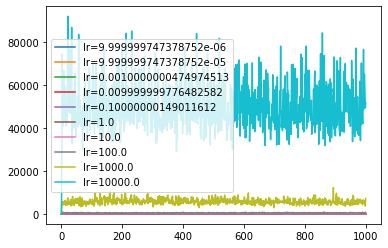

In [207]:
with torch.no_grad():
    for i in range():
        plt.plot(np.arange(1000), losses[i], label=f"lr={lr_initial_test[i]}")
    plt.legend()
    plt.show()

Since the highest and lowest learning rates don't converge, we remove them from the plot so that we can scale down and see what is happening with the relevant values.

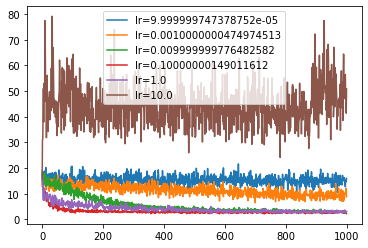

In [213]:
with torch.no_grad():
    for i in range(1, 7):
        plt.plot(np.arange(1000), losses[i], label=f"lr={lr_initial_test[i]}")
    plt.legend()
    plt.show()

Here, we see that only really the $\text{learning rates} \in [0.0001, 1]$ converge.